# Otros algoritmos de aprendizaje

Tips and tricks para el aprendizaje

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from tensorflow.keras import regularizers
import os

2023-10-02 18:41:43.938470: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 18:41:43.984444: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 18:41:43.985438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 18:41:45.014888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Elegir el optimizador

Muchas veces elegir el optimizador adecuado puede cambiar significativamente el desempeño de nuestro entrenamiento



In [2]:
# Cargar la base de datos de números
digits = load_digits()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo de la red neuronal
model = keras.Sequential([
    # Red de entrada
    keras.layers.Input(shape=(64,)),  # Capa de entrada con 64 características
    keras.layers.Dense(128, activation='relu'),  # Capa oculta con 128 neuronas y función de activación ReLU
    keras.layers.Dense(10, activation='softmax')  # Capa de salida con 10 neuronas para clasificar 10 clases (números del 0 al 9)
])

scce = tf.keras.losses.SparseCategoricalCrossentropy()

loss0 = scce(y_train, model.predict(X_train)).numpy()
#loss = model.evaluate(X_train, y_train)
print(f"Loss: {loss0}")

model.save_weights('modelo_base.h5')


45/45 [==============================] - 0s 2ms/step
Loss: 2.468902349472046


In [3]:
modelos = dict()
for optimizador in ["SGD","Adagrad","Adam","Nadam"]:

    model.load_weights('modelo_base.h5')

    # Compilar el modelo
    model.compile(optimizer=optimizador, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    print(optimizador)
    # Subdividimos train para generar métricas la validación es interna
    modelos[optimizador] = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, verbose=0)



SGD
Adagrad
Adam
Nadam


In [4]:
modelos["Nadam"].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

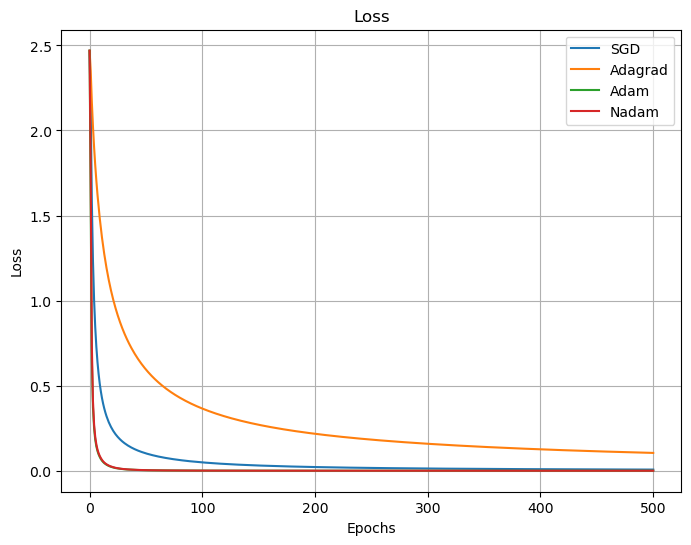

In [5]:
plt.figure(figsize=(8, 6))  # Adjust the figure size

for llave in modelos:
    #print(modelos[llave].history["loss"])
    #plt.semilogy([loss0]+modelos[llave].history["loss"], label=llave)
    plt.plot([loss0]+modelos[llave].history["loss"], label=llave)
    #plt.plot([loss0]+modelos[llave].history["val_accuracy"], label=llave)

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Show the plot
plt.grid(True)  # Add grid lines

# Inicializadores

podemos elegir los pesos iniciales, recordemos que queremos hacer una optimización de estos pesos. Así que si elegimos de marera correcta será mucho mas rápido.


In [6]:
from tensorflow.keras import initializers

In [11]:
modelos = dict()
inicalizadores = {
    "RandomNormal":initializers.RandomNormal(seed=2023), #Campana de Gauss (media cero, distrib normal 1)
    "RandomUniform":initializers.RandomUniform(seed=2023), # Todos los números igual de probables
    "Zeros":initializers.Zeros(),
    "Ones":initializers.Ones(),
    "GlorotNormal":initializers.GlorotNormal(seed=2023),  # Gauss transformada (media o distrib normal diferentes)
    "HeNormal":initializers.HeNormal(seed=2023),       # Gauss transformada (media o distrib normal diferentes)
}
for inicial in inicalizadores:

    model = keras.Sequential([
        keras.layers.Input(shape=(64,)),  # Capa de entrada con 64 características
        keras.layers.Dense(128, activation='relu', kernel_initializer=inicalizadores[inicial]),  # Capa oculta con 128 neuronas y función de activación ReLU
        keras.layers.Dense(10, activation='softmax', kernel_initializer=inicalizadores[inicial])  # Capa de salida con 10 neuronas para clasificar 10 clases (números del 0 al 9)
    ])

    # Compilar el modelo
    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    print(inicial)
    modelos[inicial] = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)



RandomNormal
RandomUniform
Zeros
Ones
GlorotNormal
HeNormal


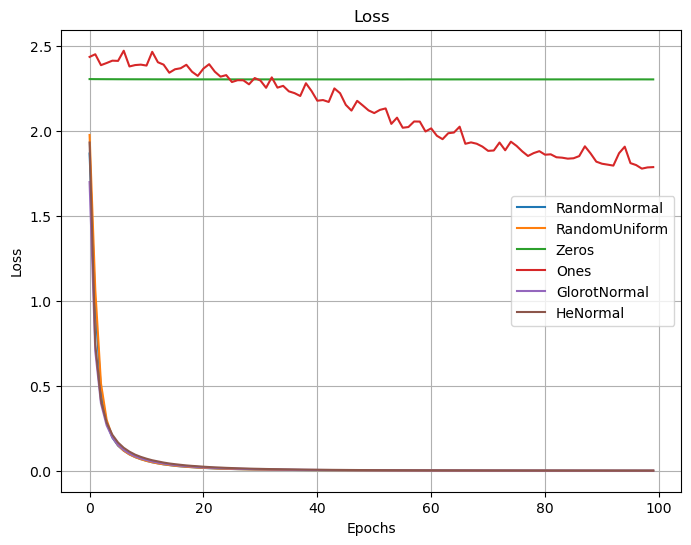

In [12]:
plt.figure(figsize=(8, 6))  # Adjust the figure size

for llave in modelos:
    #plt.semilogy(modelos[llave].history["loss"], label=llave)
    plt.plot(modelos[llave].history["loss"], label=llave)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.grid(True)

# Entrenamiento en GPU

Las siguientes secciones tendran un entrenamiento mas serio lo cual puede requerir algo de tiempo. Por lo que haremos uso de las GPU que nos da colab

In [ ]:
# correr en colab
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Dropout

Es una técnica de regularización que se aplica durante el entrenamiento de una red neuronal. Durante cada paso de entrenamiento, se apaga (desactiva) de forma aleatoria un conjunto de neuronas en una capa, lo que significa que sus salidas se establecen en cero. Esto se hace independientemente para cada neurona y en cada paso de entrenamiento.



![esquema dropout](https://i.stack.imgur.com/CewjH.png)


Es eficaz para reducir el sobreajuste. Al apagar las neuronas, se evita que la red se vuelva demasiado dependiente de características específicas o conexiones, lo que mejora la generalización del modelo a datos no vistos.

## Ejemplo


In [25]:
X, y = make_moons(n_samples=200, noise=0.3, random_state=123)

In [26]:
#from sklearn import datasets

#X, y = make_circles(n_samples=100, noise=0.1, random_state=1)

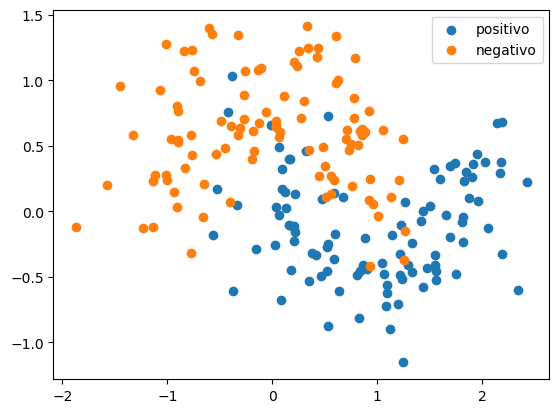

In [27]:
plt.scatter(X[y==1,0],X[y==1,1],label="positivo")
plt.scatter(X[y==0,0],X[y==0,1],label="negativo")
plt.legend()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [29]:
modelo_simple = keras.Sequential()  # red hacia adelante
modelo_simple.add(keras.layers.Dense(500, input_dim=2, activation='relu')) #Una capa oculta de 500 neur entrada dos neuronas
modelo_simple.add(keras.layers.Dense(1, activation='sigmoid')) # Una salida
modelo_simple.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_simple = modelo_simple.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000)


Epoch 1/1000
5/5 [==============================] - 1s 51ms/step - loss: 0.6690 - accuracy: 0.7214 - val_loss: 0.6234 - val_accuracy: 0.8167
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6215 - accuracy: 0.7571 - val_loss: 0.5717 - val_accuracy: 0.8167
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.5803 - accuracy: 0.7643 - val_loss: 0.5293 - val_accuracy: 0.8333
Epoch 4/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.5476 - accuracy: 0.7571 - val_loss: 0.4924 - val_accuracy: 0.8333
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5173 - accuracy: 0.7714 - val_loss: 0.4616 - val_accuracy: 0.8333
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4930 - accuracy: 0.7786 - val_loss: 0.4345 - val_accuracy: 0.8500
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4702 - accuracy: 0.7786 - val_loss: 0.4131 - val_accuracy: 0.8833
Epoch 8/1000


Epoch 59/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3356 - accuracy: 0.8571 - val_loss: 0.3303 - val_accuracy: 0.8667
Epoch 60/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3351 - accuracy: 0.8571 - val_loss: 0.3290 - val_accuracy: 0.8667
Epoch 61/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.3343 - accuracy: 0.8571 - val_loss: 0.3287 - val_accuracy: 0.8667
Epoch 62/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.3337 - accuracy: 0.8571 - val_loss: 0.3277 - val_accuracy: 0.8667
Epoch 63/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3334 - accuracy: 0.8643 - val_loss: 0.3278 - val_accuracy: 0.8667
Epoch 64/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3327 - accuracy: 0.8643 - val_loss: 0.3270 - val_accuracy: 0.8667
Epoch 65/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3330 - accuracy: 0.8643 - val_loss: 0.3277 - val_accuracy: 0.8833
Epoch 

5/5 [==============================] - 0s 11ms/step - loss: 0.2900 - accuracy: 0.8857 - val_loss: 0.3035 - val_accuracy: 0.9167
Epoch 117/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2887 - accuracy: 0.8857 - val_loss: 0.3029 - val_accuracy: 0.9167
Epoch 118/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2878 - accuracy: 0.8786 - val_loss: 0.3021 - val_accuracy: 0.9167
Epoch 119/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2872 - accuracy: 0.8786 - val_loss: 0.3024 - val_accuracy: 0.9167
Epoch 120/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2857 - accuracy: 0.8786 - val_loss: 0.3021 - val_accuracy: 0.9167
Epoch 121/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2848 - accuracy: 0.8786 - val_loss: 0.3014 - val_accuracy: 0.9167
Epoch 122/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2841 - accuracy: 0.8786 - val_loss: 0.3003 - val_accuracy: 0.9167
Epoch 123/1000

5/5 [==============================] - 0s 10ms/step - loss: 0.2409 - accuracy: 0.8929 - val_loss: 0.2751 - val_accuracy: 0.9167
Epoch 174/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2416 - accuracy: 0.8929 - val_loss: 0.2741 - val_accuracy: 0.9167
Epoch 175/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2398 - accuracy: 0.8929 - val_loss: 0.2755 - val_accuracy: 0.9167
Epoch 176/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2398 - accuracy: 0.9000 - val_loss: 0.2776 - val_accuracy: 0.9167
Epoch 177/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2396 - accuracy: 0.9071 - val_loss: 0.2775 - val_accuracy: 0.9167
Epoch 178/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2393 - accuracy: 0.9071 - val_loss: 0.2766 - val_accuracy: 0.9167
Epoch 179/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2375 - accuracy: 0.9000 - val_loss: 0.2753 - val_accuracy: 0.9167
Epoch 180/1000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 0.2149 - accuracy: 0.9143 - val_loss: 0.2661 - val_accuracy: 0.9167
Epoch 231/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2154 - accuracy: 0.9143 - val_loss: 0.2644 - val_accuracy: 0.9167
Epoch 232/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2148 - accuracy: 0.9143 - val_loss: 0.2642 - val_accuracy: 0.9167
Epoch 233/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2144 - accuracy: 0.9143 - val_loss: 0.2639 - val_accuracy: 0.9167
Epoch 234/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2146 - accuracy: 0.9143 - val_loss: 0.2636 - val_accuracy: 0.9167
Epoch 235/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2141 - accuracy: 0.9143 - val_loss: 0.2631 - val_accuracy: 0.9167
Epoch 236/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2138 - accuracy: 0.9143 - val_loss: 0.2628 - val_accuracy: 0.9167
Epoch 237/1000

5/5 [==============================] - 0s 8ms/step - loss: 0.1996 - accuracy: 0.9214 - val_loss: 0.2638 - val_accuracy: 0.9167
Epoch 288/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.1993 - accuracy: 0.9214 - val_loss: 0.2637 - val_accuracy: 0.9167
Epoch 289/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.1987 - accuracy: 0.9214 - val_loss: 0.2635 - val_accuracy: 0.9167
Epoch 290/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.1987 - accuracy: 0.9214 - val_loss: 0.2634 - val_accuracy: 0.9167
Epoch 291/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.1984 - accuracy: 0.9214 - val_loss: 0.2633 - val_accuracy: 0.9167
Epoch 292/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.1981 - accuracy: 0.9214 - val_loss: 0.2641 - val_accuracy: 0.9167
Epoch 293/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.1977 - accuracy: 0.9214 - val_loss: 0.2645 - val_accuracy: 0.9167
Epoch 294/1000
5/5 [=

5/5 [==============================] - 0s 10ms/step - loss: 0.1893 - accuracy: 0.9214 - val_loss: 0.2690 - val_accuracy: 0.9167
Epoch 345/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1887 - accuracy: 0.9143 - val_loss: 0.2693 - val_accuracy: 0.9167
Epoch 346/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1886 - accuracy: 0.9214 - val_loss: 0.2705 - val_accuracy: 0.9167
Epoch 347/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1882 - accuracy: 0.9214 - val_loss: 0.2703 - val_accuracy: 0.9167
Epoch 348/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1885 - accuracy: 0.9214 - val_loss: 0.2695 - val_accuracy: 0.9167
Epoch 349/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1881 - accuracy: 0.9214 - val_loss: 0.2685 - val_accuracy: 0.9167
Epoch 350/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1883 - accuracy: 0.9214 - val_loss: 0.2684 - val_accuracy: 0.9167
Epoch 351/1000


5/5 [==============================] - 0s 9ms/step - loss: 0.1810 - accuracy: 0.9214 - val_loss: 0.2731 - val_accuracy: 0.9167
Epoch 402/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1811 - accuracy: 0.9214 - val_loss: 0.2736 - val_accuracy: 0.9167
Epoch 403/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1807 - accuracy: 0.9214 - val_loss: 0.2738 - val_accuracy: 0.9167
Epoch 404/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1802 - accuracy: 0.9214 - val_loss: 0.2744 - val_accuracy: 0.9167
Epoch 405/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1805 - accuracy: 0.9214 - val_loss: 0.2752 - val_accuracy: 0.9167
Epoch 406/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1804 - accuracy: 0.9214 - val_loss: 0.2754 - val_accuracy: 0.9167
Epoch 407/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1809 - accuracy: 0.9214 - val_loss: 0.2743 - val_accuracy: 0.9167
Epoch 408/1000
5/5

5/5 [==============================] - 0s 13ms/step - loss: 0.1742 - accuracy: 0.9357 - val_loss: 0.2813 - val_accuracy: 0.9167
Epoch 459/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1737 - accuracy: 0.9357 - val_loss: 0.2816 - val_accuracy: 0.9167
Epoch 460/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1740 - accuracy: 0.9357 - val_loss: 0.2829 - val_accuracy: 0.9167
Epoch 461/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1735 - accuracy: 0.9357 - val_loss: 0.2833 - val_accuracy: 0.9167
Epoch 462/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1733 - accuracy: 0.9357 - val_loss: 0.2843 - val_accuracy: 0.9167
Epoch 463/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1733 - accuracy: 0.9357 - val_loss: 0.2846 - val_accuracy: 0.9167
Epoch 464/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1731 - accuracy: 0.9357 - val_loss: 0.2841 - val_accuracy: 0.9167
Epoch 465/1000

5/5 [==============================] - 0s 9ms/step - loss: 0.1686 - accuracy: 0.9357 - val_loss: 0.2884 - val_accuracy: 0.9167
Epoch 516/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1685 - accuracy: 0.9357 - val_loss: 0.2903 - val_accuracy: 0.9167
Epoch 517/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.1682 - accuracy: 0.9357 - val_loss: 0.2914 - val_accuracy: 0.9167
Epoch 518/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1685 - accuracy: 0.9357 - val_loss: 0.2914 - val_accuracy: 0.9167
Epoch 519/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1685 - accuracy: 0.9357 - val_loss: 0.2924 - val_accuracy: 0.9167
Epoch 520/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.1692 - accuracy: 0.9429 - val_loss: 0.2930 - val_accuracy: 0.9167
Epoch 521/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1685 - accuracy: 0.9429 - val_loss: 0.2921 - val_accuracy: 0.9167
Epoch 522/1000
5

5/5 [==============================] - 0s 9ms/step - loss: 0.1620 - accuracy: 0.9357 - val_loss: 0.2983 - val_accuracy: 0.9167
Epoch 573/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1638 - accuracy: 0.9357 - val_loss: 0.2985 - val_accuracy: 0.9000
Epoch 574/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1645 - accuracy: 0.9286 - val_loss: 0.2975 - val_accuracy: 0.9000
Epoch 575/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1635 - accuracy: 0.9357 - val_loss: 0.2965 - val_accuracy: 0.9167
Epoch 576/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1624 - accuracy: 0.9357 - val_loss: 0.2970 - val_accuracy: 0.9167
Epoch 577/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1635 - accuracy: 0.9357 - val_loss: 0.2970 - val_accuracy: 0.9167
Epoch 578/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1634 - accuracy: 0.9357 - val_loss: 0.2969 - val_accuracy: 0.9167
Epoch 579/1000
5/5 [=

5/5 [==============================] - 0s 9ms/step - loss: 0.1597 - accuracy: 0.9357 - val_loss: 0.3057 - val_accuracy: 0.9167
Epoch 630/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1595 - accuracy: 0.9429 - val_loss: 0.3062 - val_accuracy: 0.9167
Epoch 631/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.1594 - accuracy: 0.9429 - val_loss: 0.3064 - val_accuracy: 0.9167
Epoch 632/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1594 - accuracy: 0.9429 - val_loss: 0.3063 - val_accuracy: 0.9167
Epoch 633/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.1596 - accuracy: 0.9429 - val_loss: 0.3053 - val_accuracy: 0.9167
Epoch 634/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1590 - accuracy: 0.9357 - val_loss: 0.3046 - val_accuracy: 0.9167
Epoch 635/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1592 - accuracy: 0.9357 - val_loss: 0.3052 - val_accuracy: 0.9167
Epoch 636/1000
5/5 [=

Epoch 687/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1567 - accuracy: 0.9357 - val_loss: 0.3134 - val_accuracy: 0.8833
Epoch 688/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1565 - accuracy: 0.9286 - val_loss: 0.3129 - val_accuracy: 0.9000
Epoch 689/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1580 - accuracy: 0.9286 - val_loss: 0.3119 - val_accuracy: 0.9000
Epoch 690/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1566 - accuracy: 0.9357 - val_loss: 0.3107 - val_accuracy: 0.9000
Epoch 691/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1563 - accuracy: 0.9357 - val_loss: 0.3100 - val_accuracy: 0.9167
Epoch 692/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1558 - accuracy: 0.9429 - val_loss: 0.3094 - val_accuracy: 0.9167
Epoch 693/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1557 - accuracy: 0.9357 - val_loss: 0.3104 - val_accuracy: 0.9167

5/5 [==============================] - 0s 10ms/step - loss: 0.1530 - accuracy: 0.9429 - val_loss: 0.3155 - val_accuracy: 0.9167
Epoch 745/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1531 - accuracy: 0.9429 - val_loss: 0.3171 - val_accuracy: 0.9167
Epoch 746/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1533 - accuracy: 0.9429 - val_loss: 0.3176 - val_accuracy: 0.9167
Epoch 747/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1532 - accuracy: 0.9429 - val_loss: 0.3171 - val_accuracy: 0.9167
Epoch 748/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1536 - accuracy: 0.9429 - val_loss: 0.3156 - val_accuracy: 0.9167
Epoch 749/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1529 - accuracy: 0.9429 - val_loss: 0.3155 - val_accuracy: 0.9000
Epoch 750/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1530 - accuracy: 0.9429 - val_loss: 0.3161 - val_accuracy: 0.9000
Epoch 751/1000

5/5 [==============================] - 0s 11ms/step - loss: 0.1523 - accuracy: 0.9357 - val_loss: 0.3187 - val_accuracy: 0.9000
Epoch 802/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1519 - accuracy: 0.9357 - val_loss: 0.3175 - val_accuracy: 0.9000
Epoch 803/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1506 - accuracy: 0.9429 - val_loss: 0.3176 - val_accuracy: 0.9000
Epoch 804/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1510 - accuracy: 0.9429 - val_loss: 0.3179 - val_accuracy: 0.9167
Epoch 805/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1515 - accuracy: 0.9429 - val_loss: 0.3171 - val_accuracy: 0.9167
Epoch 806/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1508 - accuracy: 0.9429 - val_loss: 0.3155 - val_accuracy: 0.9167
Epoch 807/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1508 - accuracy: 0.9429 - val_loss: 0.3146 - val_accuracy: 0.9000
Epoch 808/1000

5/5 [==============================] - 0s 11ms/step - loss: 0.1490 - accuracy: 0.9429 - val_loss: 0.3257 - val_accuracy: 0.9000
Epoch 859/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1479 - accuracy: 0.9429 - val_loss: 0.3257 - val_accuracy: 0.9000
Epoch 860/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.1489 - accuracy: 0.9429 - val_loss: 0.3247 - val_accuracy: 0.8833
Epoch 861/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.1485 - accuracy: 0.9429 - val_loss: 0.3238 - val_accuracy: 0.9000
Epoch 862/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1478 - accuracy: 0.9429 - val_loss: 0.3223 - val_accuracy: 0.9000
Epoch 863/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1475 - accuracy: 0.9429 - val_loss: 0.3225 - val_accuracy: 0.9167
Epoch 864/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1477 - accuracy: 0.9429 - val_loss: 0.3235 - val_accuracy: 0.9167
Epoch 865/1000

5/5 [==============================] - 0s 11ms/step - loss: 0.1454 - accuracy: 0.9429 - val_loss: 0.3264 - val_accuracy: 0.9167
Epoch 916/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1451 - accuracy: 0.9429 - val_loss: 0.3273 - val_accuracy: 0.9000
Epoch 917/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1456 - accuracy: 0.9429 - val_loss: 0.3275 - val_accuracy: 0.8833
Epoch 918/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1452 - accuracy: 0.9429 - val_loss: 0.3271 - val_accuracy: 0.8833
Epoch 919/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1446 - accuracy: 0.9429 - val_loss: 0.3267 - val_accuracy: 0.9000
Epoch 920/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1457 - accuracy: 0.9429 - val_loss: 0.3273 - val_accuracy: 0.9167
Epoch 921/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1452 - accuracy: 0.9429 - val_loss: 0.3246 - val_accuracy: 0.9000
Epoch 922/1000

5/5 [==============================] - 0s 11ms/step - loss: 0.1430 - accuracy: 0.9429 - val_loss: 0.3322 - val_accuracy: 0.8833
Epoch 973/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1434 - accuracy: 0.9429 - val_loss: 0.3325 - val_accuracy: 0.8833
Epoch 974/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1437 - accuracy: 0.9429 - val_loss: 0.3313 - val_accuracy: 0.8833
Epoch 975/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1428 - accuracy: 0.9429 - val_loss: 0.3315 - val_accuracy: 0.8833
Epoch 976/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1433 - accuracy: 0.9429 - val_loss: 0.3336 - val_accuracy: 0.9000
Epoch 977/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1436 - accuracy: 0.9429 - val_loss: 0.3337 - val_accuracy: 0.9000
Epoch 978/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1435 - accuracy: 0.9429 - val_loss: 0.3342 - val_accuracy: 0.9000
Epoch 979/1000

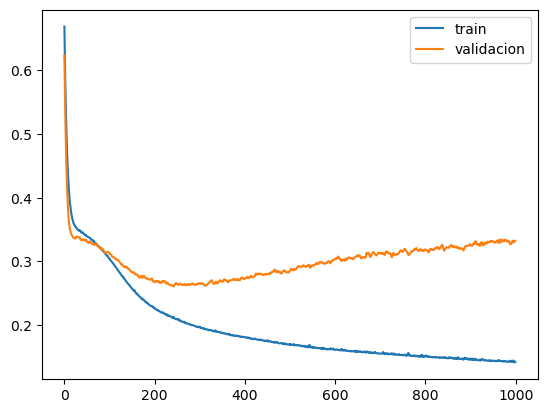

In [30]:
plt.plot(history_simple.history['loss'], label='train')
plt.plot(history_simple.history['val_loss'], label='validacion')
plt.legend()

# Si loss baja pero val loss sube es sobreajuste

In [31]:
X1_min = X[:, 0].min() - 0.1
X1_max = X[:, 0].max() + 0.1
X2_min = X[:, 1].min() - 0.1
X2_max = X[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.linspace(X1_min, X1_max, 100), np.linspace(X2_min, X2_max, 100))


313/313 [==============================] - 1s 2ms/step


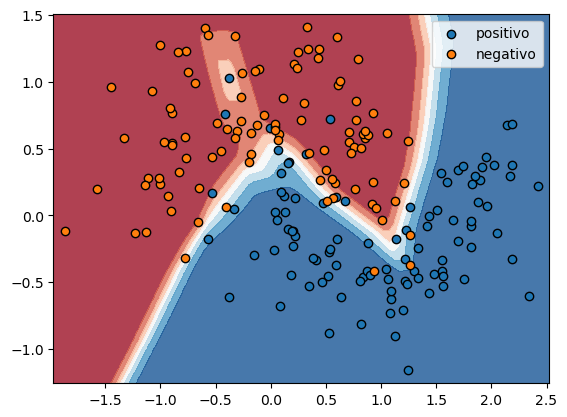

In [32]:

Z = modelo_simple.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)

plt.scatter(X[y==1,0],X[y==1,1],label="positivo", edgecolor='k')
plt.scatter(X[y==0,0],X[y==0,1],label="negativo", edgecolor='k')
plt.legend()


In [33]:
# Mismo modelo pero con dropout
modelo_drop = keras.Sequential()
modelo_drop.add(keras.layers.Dense(500, input_dim=2, activation='relu'))
modelo_drop.add(keras.layers.Dropout(0.4)) #0.4 cantidad en porcentaje de neuronas a desactivar
modelo_drop.add(keras.layers.Dense(1, activation='sigmoid'))
modelo_drop.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  #Its just a method which does configuration

In [34]:
#with tf.device('/device:GPU:0'):
history_drop = modelo_drop.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000)

Epoch 1/1000
5/5 [==============================] - 1s 41ms/step - loss: 0.6685 - accuracy: 0.6429 - val_loss: 0.6166 - val_accuracy: 0.8333
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6183 - accuracy: 0.7714 - val_loss: 0.5681 - val_accuracy: 0.8333
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.5789 - accuracy: 0.7929 - val_loss: 0.5266 - val_accuracy: 0.8333
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5518 - accuracy: 0.7643 - val_loss: 0.4908 - val_accuracy: 0.8333
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5211 - accuracy: 0.7571 - val_loss: 0.4611 - val_accuracy: 0.8333
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4951 - accuracy: 0.7929 - val_loss: 0.4373 - val_accuracy: 0.8833
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.4732 - accuracy: 0.7857 - val_loss: 0.4185 - val_accuracy: 0.8833
Epoch 8/1000


Epoch 59/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.3334 - accuracy: 0.8643 - val_loss: 0.3280 - val_accuracy: 0.8667
Epoch 60/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3407 - accuracy: 0.8714 - val_loss: 0.3281 - val_accuracy: 0.8667
Epoch 61/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.3315 - accuracy: 0.8714 - val_loss: 0.3285 - val_accuracy: 0.8667
Epoch 62/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.3383 - accuracy: 0.8571 - val_loss: 0.3283 - val_accuracy: 0.8667
Epoch 63/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3371 - accuracy: 0.8500 - val_loss: 0.3282 - val_accuracy: 0.8667
Epoch 64/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.3354 - accuracy: 0.8571 - val_loss: 0.3278 - val_accuracy: 0.8667
Epoch 65/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.3294 - accuracy: 0.8571 - val_loss: 0.3276 - val_accuracy: 0.8667
Epoch 

5/5 [==============================] - 0s 10ms/step - loss: 0.3055 - accuracy: 0.8786 - val_loss: 0.3068 - val_accuracy: 0.9000
Epoch 117/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.3098 - accuracy: 0.8571 - val_loss: 0.3063 - val_accuracy: 0.9000
Epoch 118/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.3009 - accuracy: 0.8786 - val_loss: 0.3051 - val_accuracy: 0.9000
Epoch 119/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.3070 - accuracy: 0.8714 - val_loss: 0.3043 - val_accuracy: 0.9000
Epoch 120/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.3022 - accuracy: 0.8786 - val_loss: 0.3040 - val_accuracy: 0.9167
Epoch 121/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2955 - accuracy: 0.8857 - val_loss: 0.3036 - val_accuracy: 0.9167
Epoch 122/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.3048 - accuracy: 0.8786 - val_loss: 0.3023 - val_accuracy: 0.9167
Epoch 123/1000

5/5 [==============================] - 0s 10ms/step - loss: 0.2609 - accuracy: 0.8714 - val_loss: 0.2797 - val_accuracy: 0.9167
Epoch 174/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2632 - accuracy: 0.8929 - val_loss: 0.2792 - val_accuracy: 0.9167
Epoch 175/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2586 - accuracy: 0.8929 - val_loss: 0.2796 - val_accuracy: 0.9167
Epoch 176/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2615 - accuracy: 0.8857 - val_loss: 0.2792 - val_accuracy: 0.9167
Epoch 177/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2578 - accuracy: 0.8929 - val_loss: 0.2795 - val_accuracy: 0.9167
Epoch 178/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2561 - accuracy: 0.8786 - val_loss: 0.2792 - val_accuracy: 0.9167
Epoch 179/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2571 - accuracy: 0.8857 - val_loss: 0.2781 - val_accuracy: 0.9167
Epoch 180/1000
5/5 [

5/5 [==============================] - 0s 12ms/step - loss: 0.2288 - accuracy: 0.9143 - val_loss: 0.2682 - val_accuracy: 0.9167
Epoch 231/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2346 - accuracy: 0.9071 - val_loss: 0.2685 - val_accuracy: 0.9167
Epoch 232/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2329 - accuracy: 0.9071 - val_loss: 0.2685 - val_accuracy: 0.9167
Epoch 233/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2375 - accuracy: 0.9000 - val_loss: 0.2683 - val_accuracy: 0.9167
Epoch 234/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2366 - accuracy: 0.9071 - val_loss: 0.2679 - val_accuracy: 0.9167
Epoch 235/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2356 - accuracy: 0.9000 - val_loss: 0.2674 - val_accuracy: 0.9167
Epoch 236/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2306 - accuracy: 0.9143 - val_loss: 0.2674 - val_accuracy: 0.9167
Epoch 237/1000
5/

5/5 [==============================] - 0s 11ms/step - loss: 0.2204 - accuracy: 0.9000 - val_loss: 0.2640 - val_accuracy: 0.9167
Epoch 288/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2111 - accuracy: 0.9143 - val_loss: 0.2642 - val_accuracy: 0.9167
Epoch 289/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2231 - accuracy: 0.9214 - val_loss: 0.2644 - val_accuracy: 0.9167
Epoch 290/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.2092 - accuracy: 0.9214 - val_loss: 0.2641 - val_accuracy: 0.9167
Epoch 291/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2257 - accuracy: 0.8929 - val_loss: 0.2638 - val_accuracy: 0.9167
Epoch 292/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2211 - accuracy: 0.9143 - val_loss: 0.2634 - val_accuracy: 0.9167
Epoch 293/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2252 - accuracy: 0.9000 - val_loss: 0.2626 - val_accuracy: 0.9167
Epoch 294/1000
5

5/5 [==============================] - 0s 11ms/step - loss: 0.2097 - accuracy: 0.9143 - val_loss: 0.2649 - val_accuracy: 0.9167
Epoch 345/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2131 - accuracy: 0.9071 - val_loss: 0.2644 - val_accuracy: 0.9167
Epoch 346/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1987 - accuracy: 0.9214 - val_loss: 0.2635 - val_accuracy: 0.9167
Epoch 347/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2135 - accuracy: 0.9000 - val_loss: 0.2628 - val_accuracy: 0.9167
Epoch 348/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2106 - accuracy: 0.9143 - val_loss: 0.2620 - val_accuracy: 0.9167
Epoch 349/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.2016 - accuracy: 0.9214 - val_loss: 0.2611 - val_accuracy: 0.9167
Epoch 350/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2072 - accuracy: 0.9143 - val_loss: 0.2613 - val_accuracy: 0.9167
Epoch 351/1000

5/5 [==============================] - 0s 9ms/step - loss: 0.2203 - accuracy: 0.9000 - val_loss: 0.2636 - val_accuracy: 0.9167
Epoch 402/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2169 - accuracy: 0.9214 - val_loss: 0.2627 - val_accuracy: 0.9167
Epoch 403/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2090 - accuracy: 0.9071 - val_loss: 0.2614 - val_accuracy: 0.9167
Epoch 404/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2051 - accuracy: 0.9214 - val_loss: 0.2614 - val_accuracy: 0.9167
Epoch 405/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.2096 - accuracy: 0.9286 - val_loss: 0.2605 - val_accuracy: 0.9167
Epoch 406/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1916 - accuracy: 0.9214 - val_loss: 0.2603 - val_accuracy: 0.9167
Epoch 407/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.2064 - accuracy: 0.9000 - val_loss: 0.2602 - val_accuracy: 0.9167
Epoch 408/1000


5/5 [==============================] - 0s 12ms/step - loss: 0.1995 - accuracy: 0.9143 - val_loss: 0.2648 - val_accuracy: 0.9167
Epoch 459/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.2122 - accuracy: 0.9143 - val_loss: 0.2636 - val_accuracy: 0.9167
Epoch 460/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1912 - accuracy: 0.9071 - val_loss: 0.2623 - val_accuracy: 0.9167
Epoch 461/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1986 - accuracy: 0.9214 - val_loss: 0.2614 - val_accuracy: 0.9167
Epoch 462/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.2133 - accuracy: 0.9143 - val_loss: 0.2613 - val_accuracy: 0.9167
Epoch 463/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1855 - accuracy: 0.9071 - val_loss: 0.2618 - val_accuracy: 0.9167
Epoch 464/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.2008 - accuracy: 0.9286 - val_loss: 0.2624 - val_accuracy: 0.9167
Epoch 465/1000

5/5 [==============================] - 0s 12ms/step - loss: 0.1930 - accuracy: 0.9357 - val_loss: 0.2659 - val_accuracy: 0.9167
Epoch 516/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.2019 - accuracy: 0.9286 - val_loss: 0.2660 - val_accuracy: 0.9167
Epoch 517/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1848 - accuracy: 0.9214 - val_loss: 0.2652 - val_accuracy: 0.9167
Epoch 518/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1817 - accuracy: 0.9357 - val_loss: 0.2645 - val_accuracy: 0.9167
Epoch 519/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1773 - accuracy: 0.9143 - val_loss: 0.2647 - val_accuracy: 0.9167
Epoch 520/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1924 - accuracy: 0.9214 - val_loss: 0.2660 - val_accuracy: 0.9167
Epoch 521/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1945 - accuracy: 0.9214 - val_loss: 0.2665 - val_accuracy: 0.9167
Epoch 522/1000

5/5 [==============================] - 0s 13ms/step - loss: 0.1714 - accuracy: 0.9286 - val_loss: 0.2697 - val_accuracy: 0.9167
Epoch 573/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2005 - accuracy: 0.9214 - val_loss: 0.2685 - val_accuracy: 0.9167
Epoch 574/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1833 - accuracy: 0.9286 - val_loss: 0.2681 - val_accuracy: 0.9167
Epoch 575/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1701 - accuracy: 0.9286 - val_loss: 0.2674 - val_accuracy: 0.9167
Epoch 576/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1786 - accuracy: 0.9214 - val_loss: 0.2669 - val_accuracy: 0.9167
Epoch 577/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1951 - accuracy: 0.9357 - val_loss: 0.2682 - val_accuracy: 0.9167
Epoch 578/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1930 - accuracy: 0.9143 - val_loss: 0.2698 - val_accuracy: 0.9167
Epoch 579/1000

5/5 [==============================] - 0s 12ms/step - loss: 0.1959 - accuracy: 0.9286 - val_loss: 0.2728 - val_accuracy: 0.9167
Epoch 630/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1803 - accuracy: 0.9357 - val_loss: 0.2732 - val_accuracy: 0.9167
Epoch 631/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1792 - accuracy: 0.9286 - val_loss: 0.2750 - val_accuracy: 0.9167
Epoch 632/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1875 - accuracy: 0.9143 - val_loss: 0.2752 - val_accuracy: 0.9167
Epoch 633/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2053 - accuracy: 0.9143 - val_loss: 0.2769 - val_accuracy: 0.9167
Epoch 634/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1937 - accuracy: 0.9214 - val_loss: 0.2780 - val_accuracy: 0.9167
Epoch 635/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1888 - accuracy: 0.9286 - val_loss: 0.2752 - val_accuracy: 0.9167
Epoch 636/1000

5/5 [==============================] - 0s 11ms/step - loss: 0.1733 - accuracy: 0.9357 - val_loss: 0.2807 - val_accuracy: 0.9167
Epoch 687/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1894 - accuracy: 0.9071 - val_loss: 0.2791 - val_accuracy: 0.9167
Epoch 688/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1860 - accuracy: 0.9357 - val_loss: 0.2789 - val_accuracy: 0.9167
Epoch 689/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1763 - accuracy: 0.9357 - val_loss: 0.2790 - val_accuracy: 0.9167
Epoch 690/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1724 - accuracy: 0.9357 - val_loss: 0.2794 - val_accuracy: 0.9167
Epoch 691/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1849 - accuracy: 0.9357 - val_loss: 0.2794 - val_accuracy: 0.9167
Epoch 692/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1905 - accuracy: 0.9214 - val_loss: 0.2798 - val_accuracy: 0.9167
Epoch 693/1000

5/5 [==============================] - 0s 12ms/step - loss: 0.1860 - accuracy: 0.9143 - val_loss: 0.2817 - val_accuracy: 0.9167
Epoch 744/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1695 - accuracy: 0.9357 - val_loss: 0.2827 - val_accuracy: 0.9167
Epoch 745/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1661 - accuracy: 0.9357 - val_loss: 0.2832 - val_accuracy: 0.9167
Epoch 746/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.1809 - accuracy: 0.9214 - val_loss: 0.2823 - val_accuracy: 0.9167
Epoch 747/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.1699 - accuracy: 0.9357 - val_loss: 0.2807 - val_accuracy: 0.9167
Epoch 748/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.1898 - accuracy: 0.9214 - val_loss: 0.2811 - val_accuracy: 0.9167
Epoch 749/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1799 - accuracy: 0.9214 - val_loss: 0.2813 - val_accuracy: 0.9167
Epoch 750/1000

5/5 [==============================] - 0s 10ms/step - loss: 0.1831 - accuracy: 0.9214 - val_loss: 0.2902 - val_accuracy: 0.9000
Epoch 801/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1767 - accuracy: 0.9286 - val_loss: 0.2897 - val_accuracy: 0.9000
Epoch 802/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1916 - accuracy: 0.9357 - val_loss: 0.2908 - val_accuracy: 0.9000
Epoch 803/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1810 - accuracy: 0.9143 - val_loss: 0.2897 - val_accuracy: 0.9000
Epoch 804/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1683 - accuracy: 0.9214 - val_loss: 0.2898 - val_accuracy: 0.9000
Epoch 805/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.2013 - accuracy: 0.9286 - val_loss: 0.2917 - val_accuracy: 0.9000
Epoch 806/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1716 - accuracy: 0.9143 - val_loss: 0.2911 - val_accuracy: 0.9000
Epoch 807/1000

5/5 [==============================] - 0s 12ms/step - loss: 0.1839 - accuracy: 0.9357 - val_loss: 0.2879 - val_accuracy: 0.9167
Epoch 858/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1918 - accuracy: 0.9071 - val_loss: 0.2893 - val_accuracy: 0.9167
Epoch 859/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1904 - accuracy: 0.9071 - val_loss: 0.2912 - val_accuracy: 0.9167
Epoch 860/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.1820 - accuracy: 0.9214 - val_loss: 0.2890 - val_accuracy: 0.9167
Epoch 861/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.1883 - accuracy: 0.9214 - val_loss: 0.2890 - val_accuracy: 0.9167
Epoch 862/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1563 - accuracy: 0.9429 - val_loss: 0.2890 - val_accuracy: 0.9167
Epoch 863/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1613 - accuracy: 0.9429 - val_loss: 0.2891 - val_accuracy: 0.9167
Epoch 864/1000

5/5 [==============================] - 0s 10ms/step - loss: 0.1693 - accuracy: 0.9286 - val_loss: 0.2922 - val_accuracy: 0.9167
Epoch 915/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1659 - accuracy: 0.9286 - val_loss: 0.2911 - val_accuracy: 0.9000
Epoch 916/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1753 - accuracy: 0.9214 - val_loss: 0.2900 - val_accuracy: 0.9000
Epoch 917/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1693 - accuracy: 0.9286 - val_loss: 0.2900 - val_accuracy: 0.9000
Epoch 918/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.1763 - accuracy: 0.9214 - val_loss: 0.2911 - val_accuracy: 0.8833
Epoch 919/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.1890 - accuracy: 0.9214 - val_loss: 0.2919 - val_accuracy: 0.9167
Epoch 920/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1685 - accuracy: 0.9500 - val_loss: 0.2926 - val_accuracy: 0.9167
Epoch 921/1000

5/5 [==============================] - 0s 9ms/step - loss: 0.1646 - accuracy: 0.9357 - val_loss: 0.2916 - val_accuracy: 0.8833
Epoch 972/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1846 - accuracy: 0.9429 - val_loss: 0.2929 - val_accuracy: 0.9000
Epoch 973/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1695 - accuracy: 0.9286 - val_loss: 0.2967 - val_accuracy: 0.9000
Epoch 974/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1874 - accuracy: 0.9214 - val_loss: 0.2993 - val_accuracy: 0.9000
Epoch 975/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1859 - accuracy: 0.9214 - val_loss: 0.2953 - val_accuracy: 0.9000
Epoch 976/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.1773 - accuracy: 0.9429 - val_loss: 0.2932 - val_accuracy: 0.8833
Epoch 977/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.1782 - accuracy: 0.9214 - val_loss: 0.2929 - val_accuracy: 0.9000
Epoch 978/1000
5/5 

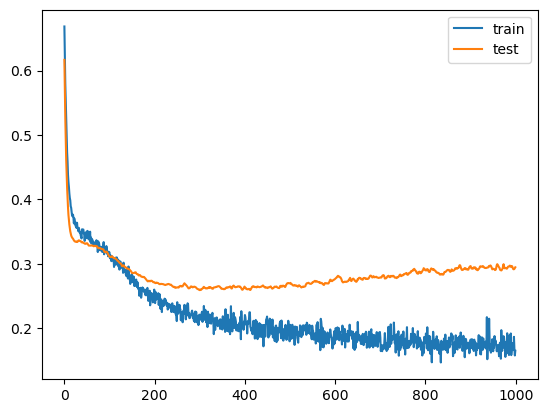

In [35]:
plt.plot(history_drop.history['loss'], label='train')
plt.plot(history_drop.history['val_loss'], label='test')
plt.legend()

313/313 [==============================] - 1s 2ms/step


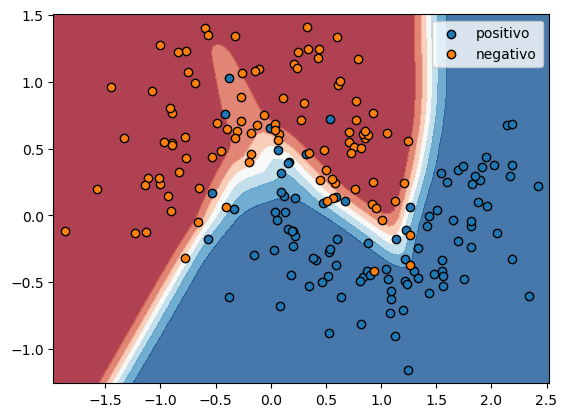

In [36]:

Z = modelo_drop.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)

plt.scatter(X[y==1,0],X[y==1,1],label="positivo", edgecolor='k')
plt.scatter(X[y==0,0],X[y==0,1],label="negativo", edgecolor='k')
plt.legend()


# Reglularización L1 y L2


Estas técnicas añaden una penalizacióon a la función de pérdida.

Ayudan a prevenir el sobreajuste (overfitting) y mejorar la generalización del modelo al penalizar los valores extremos de los pesos de las conexiones entre neuronas en una red neuronal.

## Reglularización L1

$$Loss_{L1} = Loss_{original} + \lambda \sum |w_i| $$

Donde:

- $Loss_{original}$ es la función de pérdida original del modelo.
- $\lambda$ es un hiperparámetro de regularización que controla la fuerza de la penalización.
- $w_i$ son los pesos de las conexiones en la red.


Con la regularización L1 algunos pesos son forzados a ser exactamente cero. Esto hace que la red sea más robusta y puede llevar a una selección automática de características, ya que algunos pesos se vuelven irrelevantes para la tarea y se anulan.

## Reglularización L2

$$Loss_{L2} = Loss_{original} + \lambda \sum (w_i^2) $$

Donde:

- $Loss_{original}$ es la función de pérdida original del modelo.
- $\lambda$ es un hiperparámetro de regularización que controla la fuerza de la penalización.
- $w_i$ son los pesos de las conexiones en la red.

La regularización L2 tiende a generar pesos más pequeños. Es útil cuando se desea mantener todas las características en el modelo pero evitar que los pesos se vuelvan demasiado grandes, lo que puede llevar al sobreajuste.


In [37]:
# regularizers.L1
# regularizers.L2
# regularizers.L1L2
modelo_L2 = keras.Sequential()
modelo_L2 = keras.Sequential()
modelo_L2.add(
    keras.layers.Dense(
        500,
        input_dim=2,
        activation='relu',
        kernel_regularizer=regularizers.L2(1e-4),  # en que tipo de parte tener la regularización (kerne pesos normales)
        bias_regularizer=regularizers.L2(1e-4) # bias (el número es el lambda de la formula que tan pesado es el castigo por tener pesos grandes)
    ))
modelo_L2.add(
    keras.layers.Dense(
        1,
        activation='sigmoid',
        kernel_regularizer=regularizers.L2(1e-4),
        bias_regularizer=regularizers.L2(1e-4)
        ))
modelo_L2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
modelo_L2 = keras.Sequential()
modelo_L2 = keras.Sequential()
modelo_L2.add(
    keras.layers.Dense(
        500,
        input_dim=2,
        activation='relu',
        kernel_regularizer=regularizers.L2(1e-3),
        bias_regularizer=regularizers.L2(1e-3)
    ))
modelo_L2.add(
    keras.layers.Dense(
        1,
        activation='sigmoid',
        kernel_regularizer=regularizers.L2(1e-3),
        bias_regularizer=regularizers.L2(1e-3)
        ))
modelo_L2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_L2 = modelo_L2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 104ms/step - loss: 0.6820 - accuracy: 0.6857 - val_loss: 0.6353 - val_accuracy: 0.8167
Epoch 2/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.6318 - accuracy: 0.7643 - val_loss: 0.5854 - val_accuracy: 0.8333
Epoch 3/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.5933 - accuracy: 0.7643 - val_loss: 0.5408 - val_accuracy: 0.8333
Epoch 4/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.5556 - accuracy: 0.7714 - val_loss: 0.5028 - val_accuracy: 0.8333
Epoch 5/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.5270 - accuracy: 0.7786 - val_loss: 0.4699 - val_accuracy: 0.8500
Epoch 6/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.5001 - accuracy: 0.7786 - val_loss: 0.4439 - val_accuracy: 0.8833
Epoch 7/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.4772 - accuracy: 0.7786 - val_loss: 0.4225 - val_accuracy: 0.8833
Epoch 8/1000

Epoch 59/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.3563 - accuracy: 0.8714 - val_loss: 0.3458 - val_accuracy: 0.8667
Epoch 60/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.3550 - accuracy: 0.8714 - val_loss: 0.3462 - val_accuracy: 0.8667
Epoch 61/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.3553 - accuracy: 0.8714 - val_loss: 0.3463 - val_accuracy: 0.8667
Epoch 62/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.3537 - accuracy: 0.8714 - val_loss: 0.3462 - val_accuracy: 0.8667
Epoch 63/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.3548 - accuracy: 0.8714 - val_loss: 0.3454 - val_accuracy: 0.8667
Epoch 64/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.3532 - accuracy: 0.8714 - val_loss: 0.3465 - val_accuracy: 0.8667
Epoch 65/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.3528 - accuracy: 0.8714 - val_loss: 0.3467 - val_accuracy: 0.8667
Epoch 

5/5 [==============================] - 0s 22ms/step - loss: 0.3284 - accuracy: 0.8786 - val_loss: 0.3338 - val_accuracy: 0.9000
Epoch 117/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.3276 - accuracy: 0.8857 - val_loss: 0.3339 - val_accuracy: 0.9000
Epoch 118/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.3272 - accuracy: 0.8857 - val_loss: 0.3332 - val_accuracy: 0.9000
Epoch 119/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.3266 - accuracy: 0.8857 - val_loss: 0.3336 - val_accuracy: 0.9000
Epoch 120/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.3265 - accuracy: 0.8857 - val_loss: 0.3320 - val_accuracy: 0.9000
Epoch 121/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.3254 - accuracy: 0.8857 - val_loss: 0.3322 - val_accuracy: 0.9000
Epoch 122/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.3246 - accuracy: 0.8857 - val_loss: 0.3318 - val_accuracy: 0.9000
Epoch 123/1000

5/5 [==============================] - 0s 22ms/step - loss: 0.2992 - accuracy: 0.8857 - val_loss: 0.3206 - val_accuracy: 0.9167
Epoch 174/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2987 - accuracy: 0.8857 - val_loss: 0.3207 - val_accuracy: 0.9167
Epoch 175/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2986 - accuracy: 0.8857 - val_loss: 0.3195 - val_accuracy: 0.9333
Epoch 176/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2984 - accuracy: 0.8857 - val_loss: 0.3194 - val_accuracy: 0.9167
Epoch 177/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.2979 - accuracy: 0.8857 - val_loss: 0.3193 - val_accuracy: 0.9167
Epoch 178/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.2973 - accuracy: 0.8857 - val_loss: 0.3196 - val_accuracy: 0.9167
Epoch 179/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2971 - accuracy: 0.8857 - val_loss: 0.3192 - val_accuracy: 0.9167
Epoch 180/1000

5/5 [==============================] - 0s 25ms/step - loss: 0.2835 - accuracy: 0.9071 - val_loss: 0.3206 - val_accuracy: 0.9000
Epoch 231/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.2830 - accuracy: 0.9000 - val_loss: 0.3196 - val_accuracy: 0.9000
Epoch 232/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.2841 - accuracy: 0.8929 - val_loss: 0.3198 - val_accuracy: 0.9000
Epoch 233/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.2828 - accuracy: 0.9000 - val_loss: 0.3205 - val_accuracy: 0.9000
Epoch 234/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.2822 - accuracy: 0.8929 - val_loss: 0.3208 - val_accuracy: 0.9000
Epoch 235/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.2832 - accuracy: 0.8929 - val_loss: 0.3213 - val_accuracy: 0.9000
Epoch 236/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.2818 - accuracy: 0.8929 - val_loss: 0.3193 - val_accuracy: 0.9167
Epoch 237/1000

5/5 [==============================] - 0s 21ms/step - loss: 0.2752 - accuracy: 0.9071 - val_loss: 0.3219 - val_accuracy: 0.9167
Epoch 288/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2750 - accuracy: 0.9143 - val_loss: 0.3222 - val_accuracy: 0.9167
Epoch 289/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.2749 - accuracy: 0.9143 - val_loss: 0.3215 - val_accuracy: 0.9167
Epoch 290/1000
5/5 [==============================] - 0s 29ms/step - loss: 0.2745 - accuracy: 0.9143 - val_loss: 0.3209 - val_accuracy: 0.9167
Epoch 291/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.2754 - accuracy: 0.9214 - val_loss: 0.3212 - val_accuracy: 0.9167
Epoch 292/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2744 - accuracy: 0.9143 - val_loss: 0.3206 - val_accuracy: 0.9167
Epoch 293/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.2746 - accuracy: 0.9214 - val_loss: 0.3205 - val_accuracy: 0.9167
Epoch 294/1000

5/5 [==============================] - 0s 23ms/step - loss: 0.2711 - accuracy: 0.9286 - val_loss: 0.3256 - val_accuracy: 0.9167
Epoch 345/1000
5/5 [==============================] - 0s 29ms/step - loss: 0.2706 - accuracy: 0.9214 - val_loss: 0.3254 - val_accuracy: 0.9167
Epoch 346/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.2711 - accuracy: 0.9143 - val_loss: 0.3248 - val_accuracy: 0.9167
Epoch 347/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.2708 - accuracy: 0.9286 - val_loss: 0.3245 - val_accuracy: 0.9167
Epoch 348/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.2711 - accuracy: 0.9286 - val_loss: 0.3242 - val_accuracy: 0.9167
Epoch 349/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.2704 - accuracy: 0.9286 - val_loss: 0.3242 - val_accuracy: 0.9167
Epoch 350/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.2716 - accuracy: 0.9286 - val_loss: 0.3240 - val_accuracy: 0.9167
Epoch 351/1000

5/5 [==============================] - 0s 21ms/step - loss: 0.2686 - accuracy: 0.9214 - val_loss: 0.3305 - val_accuracy: 0.9000
Epoch 402/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2685 - accuracy: 0.9214 - val_loss: 0.3315 - val_accuracy: 0.9000
Epoch 403/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2684 - accuracy: 0.9214 - val_loss: 0.3312 - val_accuracy: 0.9000
Epoch 404/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2687 - accuracy: 0.9214 - val_loss: 0.3304 - val_accuracy: 0.9167
Epoch 405/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2694 - accuracy: 0.9286 - val_loss: 0.3293 - val_accuracy: 0.9167
Epoch 406/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2689 - accuracy: 0.9286 - val_loss: 0.3291 - val_accuracy: 0.9167
Epoch 407/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2683 - accuracy: 0.9286 - val_loss: 0.3276 - val_accuracy: 0.9167
Epoch 408/1000

5/5 [==============================] - 0s 19ms/step - loss: 0.2668 - accuracy: 0.9286 - val_loss: 0.3303 - val_accuracy: 0.9167
Epoch 459/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2680 - accuracy: 0.9286 - val_loss: 0.3301 - val_accuracy: 0.9167
Epoch 460/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2674 - accuracy: 0.9286 - val_loss: 0.3302 - val_accuracy: 0.9167
Epoch 461/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.2676 - accuracy: 0.9214 - val_loss: 0.3299 - val_accuracy: 0.9000
Epoch 462/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.2676 - accuracy: 0.9214 - val_loss: 0.3286 - val_accuracy: 0.9167
Epoch 463/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2674 - accuracy: 0.9214 - val_loss: 0.3285 - val_accuracy: 0.9167
Epoch 464/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2674 - accuracy: 0.9214 - val_loss: 0.3291 - val_accuracy: 0.9167
Epoch 465/1000

5/5 [==============================] - 0s 19ms/step - loss: 0.2660 - accuracy: 0.9286 - val_loss: 0.3281 - val_accuracy: 0.9167
Epoch 516/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2659 - accuracy: 0.9286 - val_loss: 0.3293 - val_accuracy: 0.9167
Epoch 517/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2656 - accuracy: 0.9214 - val_loss: 0.3298 - val_accuracy: 0.9167
Epoch 518/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2657 - accuracy: 0.9286 - val_loss: 0.3312 - val_accuracy: 0.9167
Epoch 519/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2656 - accuracy: 0.9286 - val_loss: 0.3314 - val_accuracy: 0.9167
Epoch 520/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2656 - accuracy: 0.9286 - val_loss: 0.3305 - val_accuracy: 0.9167
Epoch 521/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.2655 - accuracy: 0.9286 - val_loss: 0.3305 - val_accuracy: 0.9167
Epoch 522/1000

5/5 [==============================] - 0s 20ms/step - loss: 0.2654 - accuracy: 0.9286 - val_loss: 0.3317 - val_accuracy: 0.9167
Epoch 573/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2651 - accuracy: 0.9286 - val_loss: 0.3314 - val_accuracy: 0.9167
Epoch 574/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2663 - accuracy: 0.9286 - val_loss: 0.3318 - val_accuracy: 0.9167
Epoch 575/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.2650 - accuracy: 0.9286 - val_loss: 0.3307 - val_accuracy: 0.9167
Epoch 576/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.2656 - accuracy: 0.9214 - val_loss: 0.3306 - val_accuracy: 0.9167
Epoch 577/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.2652 - accuracy: 0.9143 - val_loss: 0.3311 - val_accuracy: 0.9167
Epoch 578/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2653 - accuracy: 0.9143 - val_loss: 0.3310 - val_accuracy: 0.9167
Epoch 579/1000

5/5 [==============================] - 0s 22ms/step - loss: 0.2646 - accuracy: 0.9214 - val_loss: 0.3357 - val_accuracy: 0.9000
Epoch 630/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.2643 - accuracy: 0.9143 - val_loss: 0.3347 - val_accuracy: 0.9000
Epoch 631/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.2643 - accuracy: 0.9143 - val_loss: 0.3339 - val_accuracy: 0.9000
Epoch 632/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2645 - accuracy: 0.9143 - val_loss: 0.3333 - val_accuracy: 0.9000
Epoch 633/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2637 - accuracy: 0.9143 - val_loss: 0.3332 - val_accuracy: 0.9167
Epoch 634/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2642 - accuracy: 0.9143 - val_loss: 0.3323 - val_accuracy: 0.9167
Epoch 635/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.2637 - accuracy: 0.9286 - val_loss: 0.3324 - val_accuracy: 0.9167
Epoch 636/1000

5/5 [==============================] - 0s 20ms/step - loss: 0.2635 - accuracy: 0.9214 - val_loss: 0.3368 - val_accuracy: 0.9000
Epoch 687/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2638 - accuracy: 0.9214 - val_loss: 0.3368 - val_accuracy: 0.9000
Epoch 688/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2645 - accuracy: 0.9214 - val_loss: 0.3362 - val_accuracy: 0.9000
Epoch 689/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.2641 - accuracy: 0.9143 - val_loss: 0.3367 - val_accuracy: 0.9000
Epoch 690/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.2646 - accuracy: 0.9214 - val_loss: 0.3361 - val_accuracy: 0.9000
Epoch 691/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.2637 - accuracy: 0.9214 - val_loss: 0.3353 - val_accuracy: 0.9000
Epoch 692/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.2634 - accuracy: 0.9214 - val_loss: 0.3351 - val_accuracy: 0.9167
Epoch 693/1000

5/5 [==============================] - 0s 25ms/step - loss: 0.2642 - accuracy: 0.9143 - val_loss: 0.3349 - val_accuracy: 0.9000
Epoch 744/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.2638 - accuracy: 0.9143 - val_loss: 0.3356 - val_accuracy: 0.9000
Epoch 745/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.2631 - accuracy: 0.9143 - val_loss: 0.3360 - val_accuracy: 0.9000
Epoch 746/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.2630 - accuracy: 0.9214 - val_loss: 0.3364 - val_accuracy: 0.9167
Epoch 747/1000
5/5 [==============================] - 0s 29ms/step - loss: 0.2632 - accuracy: 0.9286 - val_loss: 0.3352 - val_accuracy: 0.9167
Epoch 748/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2632 - accuracy: 0.9286 - val_loss: 0.3338 - val_accuracy: 0.9167
Epoch 749/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2636 - accuracy: 0.9214 - val_loss: 0.3328 - val_accuracy: 0.9167
Epoch 750/1000

5/5 [==============================] - 0s 22ms/step - loss: 0.2630 - accuracy: 0.9286 - val_loss: 0.3361 - val_accuracy: 0.9167
Epoch 801/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2639 - accuracy: 0.9286 - val_loss: 0.3369 - val_accuracy: 0.9167
Epoch 802/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2637 - accuracy: 0.9286 - val_loss: 0.3344 - val_accuracy: 0.9167
Epoch 803/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2622 - accuracy: 0.9357 - val_loss: 0.3337 - val_accuracy: 0.9000
Epoch 804/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2632 - accuracy: 0.9214 - val_loss: 0.3344 - val_accuracy: 0.9000
Epoch 805/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2647 - accuracy: 0.9286 - val_loss: 0.3352 - val_accuracy: 0.9000
Epoch 806/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.2647 - accuracy: 0.9214 - val_loss: 0.3351 - val_accuracy: 0.9000
Epoch 807/1000

5/5 [==============================] - 0s 27ms/step - loss: 0.2627 - accuracy: 0.9286 - val_loss: 0.3334 - val_accuracy: 0.9167
Epoch 858/1000
5/5 [==============================] - 0s 29ms/step - loss: 0.2627 - accuracy: 0.9286 - val_loss: 0.3346 - val_accuracy: 0.9167
Epoch 859/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.2623 - accuracy: 0.9143 - val_loss: 0.3356 - val_accuracy: 0.9000
Epoch 860/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.2630 - accuracy: 0.9214 - val_loss: 0.3358 - val_accuracy: 0.9000
Epoch 861/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2630 - accuracy: 0.9214 - val_loss: 0.3362 - val_accuracy: 0.9000
Epoch 862/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2625 - accuracy: 0.9286 - val_loss: 0.3370 - val_accuracy: 0.9000
Epoch 863/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2628 - accuracy: 0.9286 - val_loss: 0.3368 - val_accuracy: 0.9000
Epoch 864/1000

5/5 [==============================] - 0s 20ms/step - loss: 0.2629 - accuracy: 0.9286 - val_loss: 0.3346 - val_accuracy: 0.9167
Epoch 915/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2628 - accuracy: 0.9286 - val_loss: 0.3343 - val_accuracy: 0.9167
Epoch 916/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2624 - accuracy: 0.9286 - val_loss: 0.3339 - val_accuracy: 0.9167
Epoch 917/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2627 - accuracy: 0.9357 - val_loss: 0.3325 - val_accuracy: 0.9167
Epoch 918/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.2621 - accuracy: 0.9357 - val_loss: 0.3318 - val_accuracy: 0.9167
Epoch 919/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2626 - accuracy: 0.9357 - val_loss: 0.3314 - val_accuracy: 0.9167
Epoch 920/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2625 - accuracy: 0.9286 - val_loss: 0.3313 - val_accuracy: 0.9167
Epoch 921/1000

5/5 [==============================] - 0s 21ms/step - loss: 0.2618 - accuracy: 0.9357 - val_loss: 0.3351 - val_accuracy: 0.9167
Epoch 972/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2616 - accuracy: 0.9286 - val_loss: 0.3359 - val_accuracy: 0.9000
Epoch 973/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2621 - accuracy: 0.9286 - val_loss: 0.3369 - val_accuracy: 0.9000
Epoch 974/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2627 - accuracy: 0.9286 - val_loss: 0.3370 - val_accuracy: 0.9000
Epoch 975/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2626 - accuracy: 0.9286 - val_loss: 0.3367 - val_accuracy: 0.9000
Epoch 976/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.2617 - accuracy: 0.9286 - val_loss: 0.3361 - val_accuracy: 0.9167
Epoch 977/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.2620 - accuracy: 0.9286 - val_loss: 0.3362 - val_accuracy: 0.9167
Epoch 978/1000

In [ ]:
plt.plot(history_L2.history['loss'], label='train')
plt.plot(history_L2.history['val_loss'], label='test')
plt.legend()

# Data Augmentation

Se utiliza para, como su nomnbre lo dice aumentar la cantidad de datos de entrenamiento mediante la aplicación de transformaciones y perturbaciones a los datos existentes. El objetivo principal es mejorar la generalización del modelo al exponerlo a una mayor variabilidad en los datos de entrenamiento.


Ejemplos de Transformaciones en Data Augmentation: Rotación, Traslación, Inversión, Corte Aleatorio, Aumento de Brillo/Contraste.


Edit: Un caso de uso es en reconocimiento de imágenes, en la que si rotas una imagen de un gato sigue siendo un gato, hay datos en los que agregar ruido sigue siendo de la misma categoría, hay datos que no

## Ejemplo

Ekemplo tomado de [Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls
!ls PetImages


In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = keras.layers.Rescaling(1.0 / 255)(inputs)
    x = keras.layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

In [ ]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")